In [22]:
from data_repo import ystock as ys
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import math
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
client = ys.ystock()

In [72]:
# We are going to use the S&P 500 to do the time series analysis
symbol = "HUG.TO"
df = client.getHistorical(symbol,"2y")
# print(df)
print(df['Open'])

Date
2018-05-07    11.86
2018-05-08    11.88
2018-05-09    11.87
2018-05-10    11.94
2018-05-11    11.93
              ...  
2020-04-29    14.77
2020-04-30    14.76
2020-05-01    14.53
2020-05-04    14.75
2020-05-05    14.75
Name: Open, Length: 502, dtype: float64


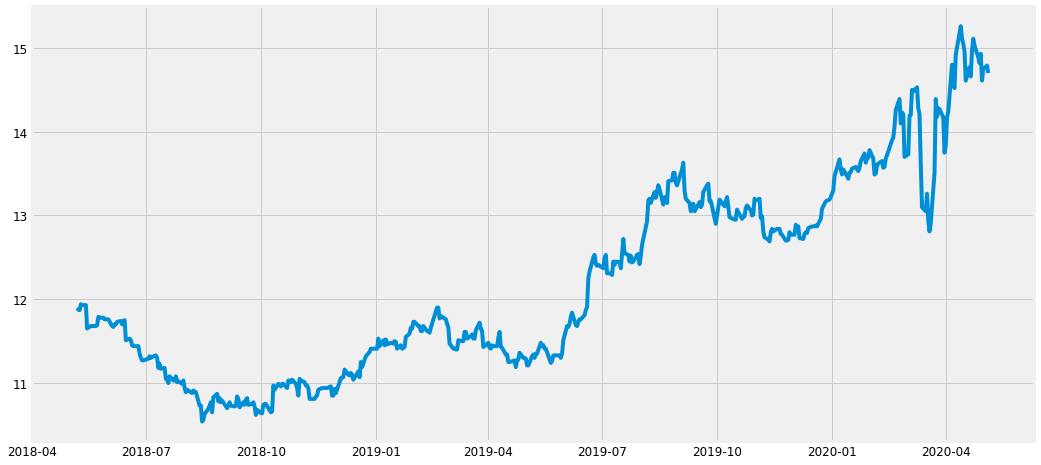

In [16]:
# df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
# df.index = df['Date']

plt.figure(figsize = (16,8))
plt.plot(df['Close'], label = "Close Price")

In [65]:
data_len = df.shape[0]
train = df[:math.floor(data_len*0.8)]
valid = df[math.floor(data_len*0.8):]
print(train.shape)
print(valid.shape)

(401, 7)
(101, 7)


In [43]:
# We first build the model with moving average
def moving_avg(data, window=1):
    res = [0 for i in range(window)]
    init_arr = df[:window-1]
    for i in range(window,data.shape[0]):
        d = data[i-window:i]
        res.append(sum(d)/window)
    return res
    

In [49]:
res = moving_avg(df['Close'],window = 10)
print(len(res))
pred = res[math.floor(data_len*0.8):]

502


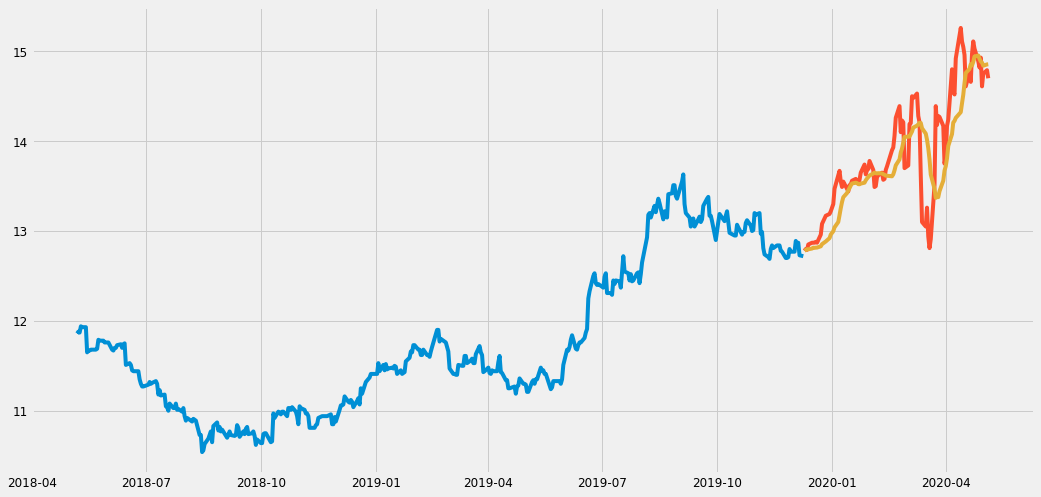

In [50]:
plt.figure(figsize = (16,8))
valid['pred'] = 0
valid['pred'] = pred
plt.plot(train['Close'])
plt.plot(valid[['Close', 'pred']])

In [51]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-pred),2)))
print('\n RMSE value on validation set:')
print(rms)
valid.drop('pred', axis = 1)


 RMSE value on validation set:
0.3944354657401682


In [66]:
# Linear Regression
from sklearn.linear_model import LinearRegression
print(valid)
print(train)
x_train = train.drop('Close', axis = 1)
y_train = train['Close']
x_valid = valid.drop('Close', axis = 1)
y_valid = valid['Close']

model = LinearRegression()
model.fit(x_train, y_train)

             Open   High    Low  Close  Volume  Dividends  Stock Splits
Date                                                                   
2019-12-10  12.80  12.80  12.75  12.78    1500          0             0
2019-12-11  12.82  12.82  12.80  12.80     300          0             0
2019-12-12  12.94  12.94  12.78  12.79   10100          0             0
2019-12-13  12.82  12.87  12.80  12.85    3600          0             0
2019-12-16  12.88  12.88  12.85  12.87    1000          0             0
...           ...    ...    ...    ...     ...        ...           ...
2020-04-29  14.77  14.93  14.75  14.93    4600          0             0
2020-04-30  14.76  14.82  14.60  14.61    4100          0             0
2020-05-01  14.53  14.75  14.53  14.75    2400          0             0
2020-05-04  14.75  14.79  14.75  14.79    3900          0             0
2020-05-05  14.75  14.78  14.70  14.78     642          0             0

[101 rows x 7 columns]
             Open   High    Low  Close  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
0.040370038779117476


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-12-10,12.80,12.80,12.75,12.78,1500,0,0
2019-12-11,12.82,12.82,12.80,12.80,300,0,0
2019-12-12,12.94,12.94,12.78,12.79,10100,0,0
2019-12-13,12.82,12.87,12.80,12.85,3600,0,0
2019-12-16,12.88,12.88,12.85,12.87,1000,0,0
...,...,...,...,...,...,...,...
2020-04-29,14.77,14.93,14.75,14.93,4600,0,0
2020-04-30,14.76,14.82,14.60,14.61,4100,0,0
2020-05-01,14.53,14.75,14.53,14.75,2400,0,0


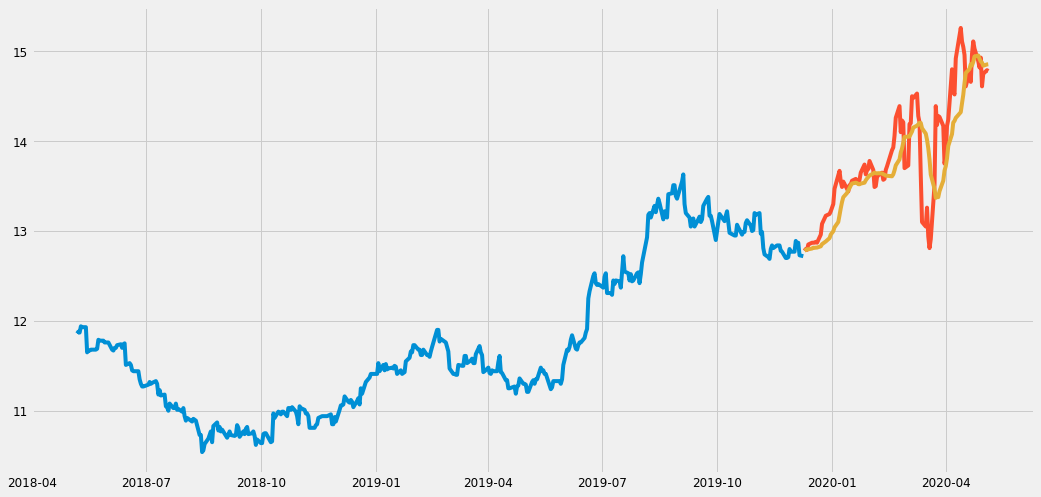

In [69]:
plt.figure(figsize = (16,8))
valid['pred'] = 0
valid['pred'] = pred
plt.plot(train['Close'])
plt.plot(valid[['Close', 'pred']])
valid.drop('pred', axis=1)

In [75]:
# SARIMA model
train_sarima = train['Close'].resample('B').fillna("backfill")
train_sarima
test_sarima = valid['Close'].resample('B').fillna("backfill")


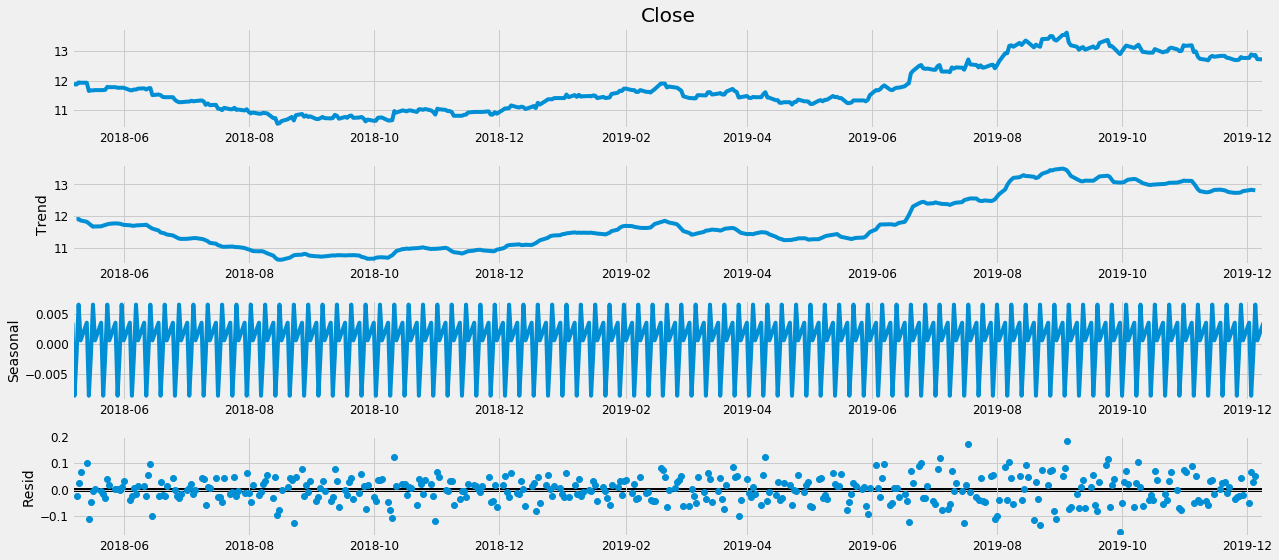

In [76]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(train_sarima, model='additive')
fig = decomposition.plot()
plt.show()

In [77]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [78]:
lowest_aic = 1000000
best_pdq = ()
best_spdq = ()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_sarima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            reaic = results.aic
            if reaic < lowest_aic:
                lowest_aic = reaic
                best_pdq = param
                best_spdq = param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
print('best aic = {}, pdq = {}, spdq = {}'.format(lowest_aic, best_pdq, best_spdq))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3227.475312288713
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2633.2348556517763
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:47.9923052614181
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:33.93424621772293
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:44.7515432152955
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:24.32047570226493
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:33.44531284146629
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:31.09027648063349
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2658.4425316279603
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2081.6889812824716
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-281.2246530861903
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-264.1295842845281
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-284.7067128283635
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-281.79224934813084
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-266.96545319153165
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-267.9289001184277
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-902.805477462591
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-882.1120682990629


In [120]:
mod = sm.tsa.statespace.SARIMAX(df['Close'][:501],
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0005      0.000   2432.175      0.000       1.000       1.001
sigma2         0.0144      0.000     38.493      0.000       0.014       0.015


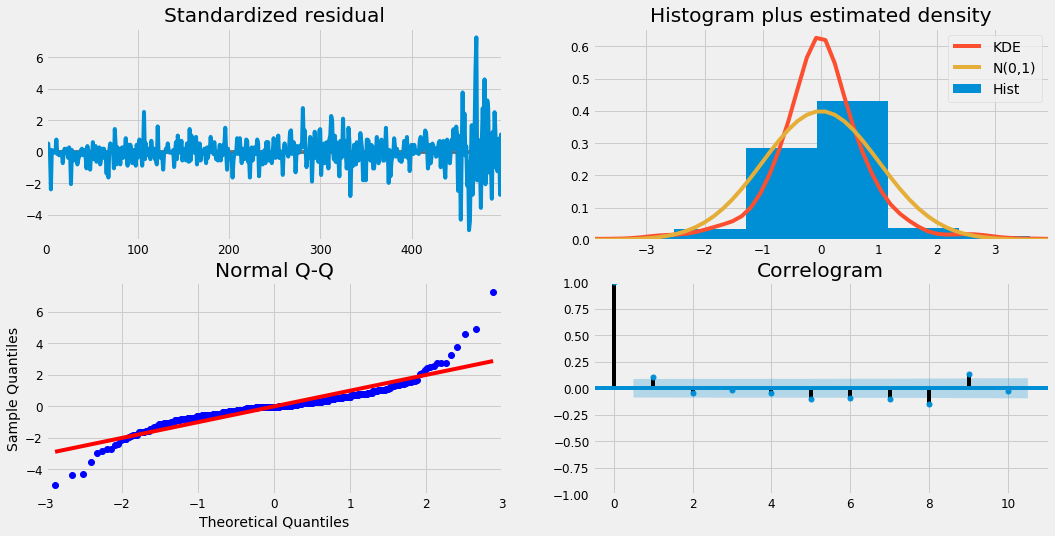

In [121]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

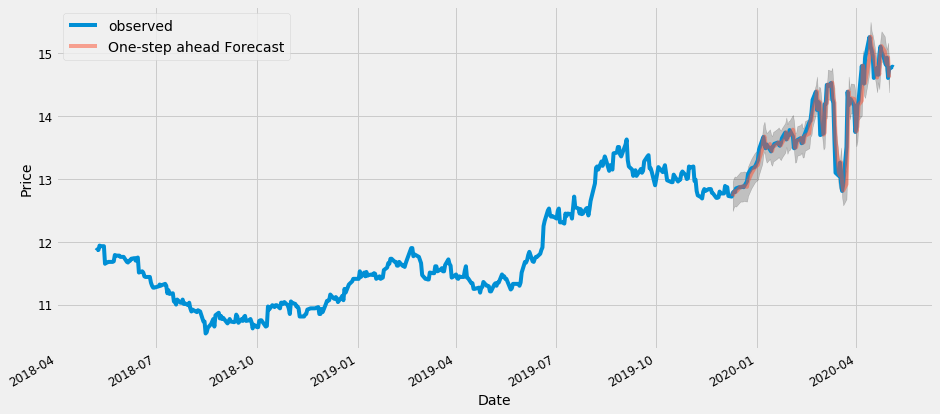

Date
2019-12-10    12.726024
2019-12-11    12.786052
2019-12-12    12.806062
2019-12-13    12.796057
2019-12-16    12.856085
                ...    
2020-04-27    15.037118
2020-04-28    14.897051
2020-04-29    14.827018
2020-04-30    14.937070
2020-05-01    14.616919
Length: 99, dtype: float64


In [122]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-10'), end = pd.to_datetime('2020-05-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['Close'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.5, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()


print(pred.predicted_mean)

In [126]:
forecast = results.get_forecast(steps =200)
predict_ci = forecast.conf_int()

ax = df['Close'].plot(label='observed', figsize=(20, 15))
print(forecast.predicted_mean)
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

501    14.797004
502    14.804012
503    14.811022
504    14.818036
505    14.825054
         ...    
696    16.228178
697    16.235864
698    16.243552
699    16.251245
700    16.258941
Length: 200, dtype: float64


ValueError: view limit minimum -36351.450000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002A87ECE6D08> (for post_execute):


ValueError: view limit minimum -36351.450000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36351.450000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1440x1080 with 1 Axes>